<a href="https://colab.research.google.com/github/JelenaKitanovic/qa_system_covid/blob/main/IR_JelenaKitanovic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem za pretraživanje informacija o virusu COVID-19 implementiran korišćenjem Haystack framework-a

Cilj projekta bio je implementacija sistem za odgovore na pitanja (tzv. QA system), koji bi na postavljeno pitanje pronašao odgovore među dostupnim dokumentima. Za realizaciju ovog projekta korišćen je [Haystack framework](https://haystack.deepset.ai/overview/intro) koji omogućava brzu i laku pretragu primenom najpopularnijih algoritama iz ove oblasti.

U ovom projektu korišćen je podskup skupa podataka 
[COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Originalni skup se sastoji od preko 500,000 stručnih radova, od kojih je preko 200,000 o COVID-19, SARS-CoV-2, i sličnim virusima. 

Napomena: Radi lakšeg treniranja i reprodukcije programa, prilkom izrade ovog projekta korišćen je podskup od oko 12,000 radova. Folder sa tim radovima mozete pronaći na ovoj adresi: https://drive.google.com/drive/folders/1MrqXb0VXad0f0skhyhgGwypdEy3khzKg?usp=sharing, i kopirati na svoj Google Drive.

###Uputstva za krajnjeg korisnika

Ukoliko se program učita kroz Google Colab, sa gronje leve strane se nalazi Sadržaj (Table of contents) koji se može koristiti radi lakše navigacije kroz sam fajl.

Na dnu ovog Colab fajla nalazi se forma za slobodan korisnički unos. Tu korisnik može postaviti pitanje i dobiće listu sa najrelevantnijim dokumentima i predloženim odgovorima. 


## Učitavanje skupa podataka

Kako su podaci u navedenom direktorijumu u JSON formatu, potrebno je da iz njih izvučemo informacije koje nam trebaju, kao i da prilagodimo format onome koji nama odgovara. 

Za dalju analizu biće nam dovoljan naziv rada (title), sažetak (abstract), sam tekst rada (full_text) i imena autora (authors).

In [1]:
import numpy as np
import pandas as pd
import os
import json
import re
from tqdm import tqdm

directory_path = "/content/drive/MyDrive/COVID"
docs = []

for filename in tqdm(os.listdir(directory_path)):
  file_path = directory_path + f"/{filename}"
  json_content = json.load(open(file_path, "rb"))
  
  paper_id = json_content['paper_id']
  title = json_content['metadata']['title']    
  authors = ''
  for author in json_content['metadata']['authors']:
    authors += author['first'] + ' ' + author['last'] + ', '
  authors = authors[:-2]
  
  #Ovde obradjujemo situaciju kada ne postoji abstract u dokumentu
  try:
    abstract = json_content['abstract'][0]['text']
  except:
    abstract = ''
            
  full_text = ''
  for text in json_content['body_text']:
    full_text += text['text']       
  
  #Dodajemo dokument u listu
  docs.append([paper_id, title, abstract, full_text, authors])  

#Od liste dokumenata napravicemo Pandas DataFrame objekat jer nam je lakse da baratamo sa njim :)
df = pd.DataFrame(docs, columns = ['paper_id', 'title', 'abstract', 'full_text', 'authors'])

100%|██████████| 12336/12336 [00:18<00:00, 679.19it/s]


In [2]:
print('Dimenzije skupa podataka:', df.shape)
print('Pregled prvih par redova:')

df.head()

Dimenzije skupa podataka: (12336, 5)
Pregled prvih par redova:


,paper_id,title,abstract,full_text,authors
0,f4151bf1d61e7808033d59606f364c02d41234ed,Akute bilaterale Vestibulopathie nach SARS-CoV...,"Wir berichten über eine 68-jährige Patientin, ...","Einschränkend bleibt natürlich festzustellen, ...",Florian Sachse
1,f42961a84c4587d2adac0afecd40abcfb0ce989d,Nursing Informatics: A Core Competency for the...,This chapter provides the reader with a summar...,Learning Objectives for the Chapter 1. Underst...,"Pamela Hussey, Kathryn Hannah, P Hussey, P Hannah"
2,f40856d6d07cfe364cffb9b4d00b7a8bc40cf679,Epidemic Investigation,,One of the key roles of public health is to ma...,"Els Mathieu, Yao Sodahlon"
3,f42578b823280a3931165040e8a79b23470df0de,"Structure, activity and inhibition of human TM...","9 Transmembrane protease, serine 2 (TMPRSS2) h...",. Engineered activation and structural charact...,"Bryan Fraser#, Serap Beldar#, Almagul Seitova,..."
4,f412033f08fe73d4affcfb381114f4ad306d7f07,HSV Forms an HCMV-like Viral Assembly Center i...,Herpes simplex virus (HSV) is a neuroinvasive ...,It is commonly observed that viruses concentra...,"Shaowen White, Hiroyuki Kawano, N Charles Hara..."


In [3]:
#Brisemo duplikate
df.drop_duplicates(inplace = True)
df.describe()

,paper_id,title,abstract,full_text,authors
count,12332,12332,12332,12332,12332
unique,12332,10863,8621,12318,11135
top,89d6f4193a09f27569eb35990e1ad6e9b4697817,,,The nuclear receptor heterodimers of liver X r...,
freq,1,1256,3635,4,1125


###Nedostajuće vrednosti

Primećujemo da imamo nedostajuće vrednosti za atribut *authors*. Hajde da ih pregledamo da vidimo da li je u pitanju greška ili baš tako treba da bude.

In [6]:
df[df['authors'] == ''].head(10)

,paper_id,title,abstract,full_text,authors
7,f40631c38739955895a09a0796722e29f1bc5512,,,The pandemic of Corona Virus Disease 2019 (COV...,
40,f4597c208f01029c3ff3abbaf444a2d250c75e9e,PLOS ONE Impact of Covid-19 pandemic on obstet...,The advent of Covid-19 pandemic adversely affe...,Short title: Effects of Covid-19 pandemic on o...,
43,f45365ece4607c0d1f38f1d98697f7a32bfe58c2,,,Background: Health care professionals (PS) are...,
47,f4607f104e185f6db161e94363a3315ae2f08f22,,,Technological advances in the field of technic...,
61,f4319d7d36e11d6b29590ea57d9cc339d0cc9048,Supplementary information,1,"(IBA). For further purification, the eluted sa...",
85,f485357fdddbbc022862d4512d19c78ded6f5b2a,,,Submissions should be made via our electronic ...,
94,f4792a84bb430aa257cbae37abe16a59ab19f6ed,Acknowledgements 6 0,,. 1 0 5 . CC-BY 4.0 International license It i...,
96,f4767a18070c219d7a4f705fc1b851d4814170a9,The Impact of COVID-19 on the Continuity of Ca...,The authors discuss the challenges and offer p...,Healthcare services globally are combating the...,
99,f49893a6de7ba4d7694ae4db2c81b35ae4bc71e0,,,The face-to-face consultations are a norm for ...,
103,f4668e1fe8dff3b9f4395316cd1caf946ed08e19,12A) A Symposium: Interventions to Prevent Chr...,,E pisodes commonly described as bronchitic exa...,


### Tretiranje nedostajućih vrednosti

Možemo primetiti da redovi koji nemaju podatak ni za polje *authors*, ni za polje *title*, su uglavnom ili loši dokumenti ili je došlo do neke greške prilikom parsiranja ulaza. Kako imamo dovoljno podataka i bez njih, takve redove ćemo ovoga puta samo ukloniti, da nam ne bi kvarili dalju analizu.

In [7]:
clean_dataframe = df[(df['authors'] != '') | (df['title'] != '')]

print("Dimenzije ociscenog skupa podataka: ", clean_dataframe.shape)
print("Pregled prvih nekoliko redova osiscenog skupa podataka: ")
clean_dataframe.head(10)

Dimenzije ociscenog skupa podataka:  (11652, 5)
Pregled prvih nekoliko redova osiscenog skupa podataka: 


,paper_id,title,abstract,full_text,authors
0,f4151bf1d61e7808033d59606f364c02d41234ed,Akute bilaterale Vestibulopathie nach SARS-CoV...,"Wir berichten über eine 68-jährige Patientin, ...","Einschränkend bleibt natürlich festzustellen, ...",Florian Sachse
1,f42961a84c4587d2adac0afecd40abcfb0ce989d,Nursing Informatics: A Core Competency for the...,This chapter provides the reader with a summar...,Learning Objectives for the Chapter 1. Underst...,"Pamela Hussey, Kathryn Hannah, P Hussey, P Hannah"
2,f40856d6d07cfe364cffb9b4d00b7a8bc40cf679,Epidemic Investigation,,One of the key roles of public health is to ma...,"Els Mathieu, Yao Sodahlon"
3,f42578b823280a3931165040e8a79b23470df0de,"Structure, activity and inhibition of human TM...","9 Transmembrane protease, serine 2 (TMPRSS2) h...",. Engineered activation and structural charact...,"Bryan Fraser#, Serap Beldar#, Almagul Seitova,..."
4,f412033f08fe73d4affcfb381114f4ad306d7f07,HSV Forms an HCMV-like Viral Assembly Center i...,Herpes simplex virus (HSV) is a neuroinvasive ...,It is commonly observed that viruses concentra...,"Shaowen White, Hiroyuki Kawano, N Charles Hara..."
5,f40717f7d6802d0df1135e8225b5c3f69e1b726f,How the COVID-19 pandemic will change the futu...,has posed unprecedented healthcare system chal...,"Since December 2019, the Coronavirus disease-1...","Yaseen Arabi, Elie Azoulay, Hasan Al-Dorzi, Ja..."
6,f4202aa37835ea8e52e0230e2c056a99d06d96f9,The misunderstanding of vaccine efficacy,Although the efficacies of vaccines against SA...,The protective effect of a vaccine is typicall...,"K Passerini, A Timberlake, B Pighin, S"
8,f4185f72f8808fa0c927ce358267368866cfa2eb,Characterizing 56 complete SARS-CoV S-gene seq...,Background: The spike glycoprotein (S) gene of...,Since the severe acute respiratory syndrome (S...,"Julian Tang, Jo Cheung, Ida Chu, Margaret Ip, ..."
9,f42669f3577a3f410cff85a4b1ad9ae5a5065c0e,0123456789) 1 3 Journal of Science in Sport an...,It is known that COVID-19 spread mainly from p...,It is known that COVID-19 spread mainly from p...,Francisco Arias
10,f4242f1af7a17ad76cb437f827ef8d1ff291a731,Disease-Suppressive Soils-Beyond Food Producti...,In the pursuit of higher food production and e...,The COVID-19 pandemic is testing the capabilit...,"Somasundaram Jayaraman, &amp; Naorem, Rattan L..."


### Oblak reči (word cloud)

Primenićemo tehniku *oblak reči* (*word cloud*), kako bismo vizuelno prikazali najčešće pojmove koji se nalaze u sažecima (*abstract*) ovih radova.

Ukupno, u svim sazecima ima 8555950 reci.


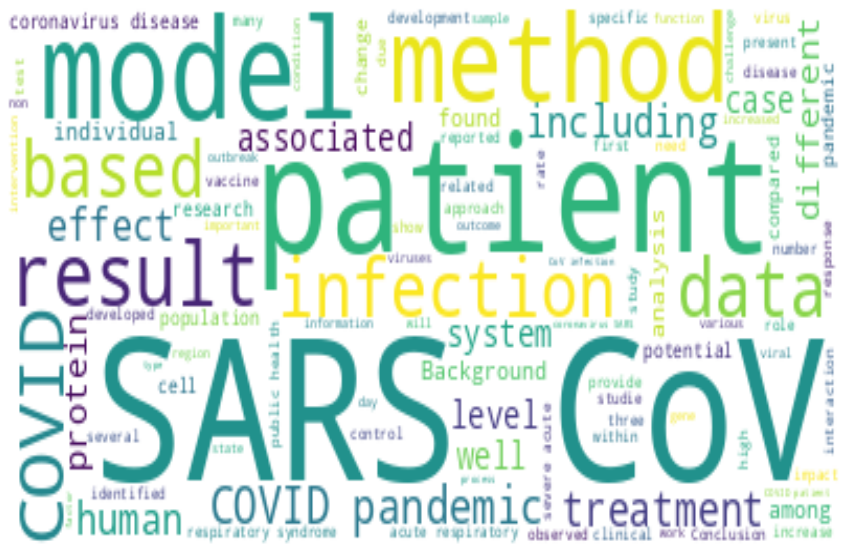

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

abstracts_merged = " ".join(title for title in clean_dataframe.abstract)
print("Ukupno, u svim sazecima ima {} reci.".format(len(abstracts_merged)))

# Izbacujemo tzv. STOPWORDS, to su reci koje se cesto ponavljaju u tekstu a ne donose dodatno znacenje, na primer veznici: and i or
stopwords = set(STOPWORDS)
# Izbacujemo jos neke cesto koriscenje reci koje nisu usko vezane za temu istrazivanja
stopwords.update(["et al", "one", "use", "group", "two", "may", "using", "used", "new", "time"])

wordcloud = WordCloud(stopwords=stopwords, background_color = "white").generate(abstracts_merged)

# Prikaz generisane slike:
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation = 'bilinear', aspect = 'auto')
plt.axis('off')
plt.show()

## Implementacija programa za pretragu informacija

Sada, kada smo odradili osnovni pregled i analizu skupa podataka, znamo sa čime radimo, pa možemo da pređemo na primenu algoritama za pretraživanje informacija.

Za izgradnju QA sistema korišćen je [Haystack framework](https://haystack.deepset.ai/overview/get-started). To je open-source sistem koji nam omogućava inteligentnu pretragu nad velikim skupom dokumenata.   

Osnovni pipeline jedne aplikacije izgleda kao na slici:
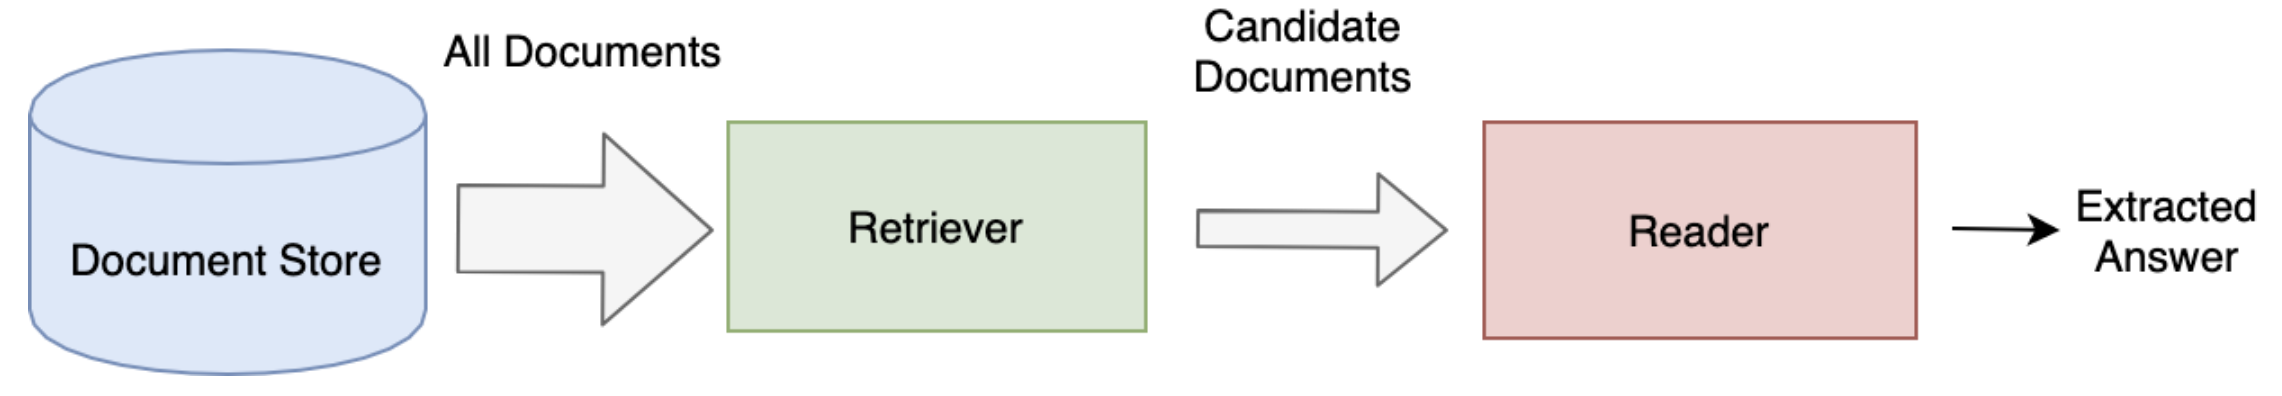


### Instalacija najnovije verzije Heystack framework-a

In [17]:
!pip install grpcio-tools==1.34.1
!pip install git+https://github.com/deepset-ai/haystack.git

     |████████████████████████████████| 2.5 MB 7.4 MB/s 
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-t3wxogg0
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-t3wxogg0
     |████████████████████████████████| 204 kB 8.2 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 321 kB 74.9 MB/s 
     |████████████████████████████████| 332 kB 58.4 MB/s 
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 981 kB 78.3 MB/s 
     |████████████████████████████████| 3.0 MB 43.3 MB/s 
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 5.6 MB 25.7 MB/s 
     |████████████████████████████████| 100 kB 13.3 MB/s 
     |████████████████████████████████| 8.4 MB 97.2 MB/s 
     |████████

### Učitavanje potrebnih funkcija i biblioteka (za konvertovanje i pripremu dokumenata za skladištenje)

In [10]:
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


### Učitavanje dokumenata u DocumentStore

Haystack traži odgovore na pitanja u dokumentima koji se nalaze u [DocumentStore](https://haystack.deepset.ai/usage/document-store)-u. Postoji više podržanih implementacija DocumentStore-a (ElasticsearchDocumentStore, SQLDocumentStore, MilvusDocumentStore, InMemoryDocumentStore, etc.)

U ovom projektu je korišćen ElasticSearchDocumentStore, zato što dolazi sa implementiranim algoritmima kao što su BM25 i full-text queries.

#### Instalacija i pokretanje ElasticSearch-a

In [13]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )

# Cekamo malo dok ES startuje
! sleep 30

# Inicijalizacija ES-a
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

09/07/2021 19:46:38 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.066s]
09/07/2021 19:46:38 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.272s]
09/07/2021 19:46:38 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.159s]


#### Transformacija i upisivanje podataka u DocumentStore

Da bismo upisali dokumente u ElasticsearchDocumentStore potrebno je da oni budu u sledećem formatu (dictionary):
<br>
[
*    {"name": "ime dokumenta 1", "text": "sadrzaj dokumenta 1"}
*    {"name": "ime dokumenta 2", "text": "sadrzaj dokumenta 2"}
*    {"name": "ime dokumenta 3", "text": "sadrzaj dokumenta 3"}

],

pa ćemo morati da dodatno transformišemo naš dataframe.


In [20]:
dictionary = clean_dataframe[['title', 'full_text']].rename(columns = {'title': 'name', 'full_text': 'text'}).to_dict(orient = 'records')

In [19]:
document_store.write_documents(dictionary)

09/07/2021 19:52:16 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.164s]
09/07/2021 19:52:18 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.285s]
09/07/2021 19:52:21 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.380s]
09/07/2021 19:52:23 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.259s]
09/07/2021 19:52:26 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.163s]
09/07/2021 19:52:28 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.190s]
09/07/2021 19:52:30 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.135s]
09/07/2021 19:52:32 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.153s]


### Inicijalizacija Retriever-a

Retriever se ponaša kao Kerber koji ne dozvoljava da svašta dođe do Reader-a :). 

On prvi pregleda sve dokumente koja se nalaze u DocumentStore-u, brzo primeti koji dokumenti su relevantni, a koji ne, i na kraju prosledi filtrirani skup dokumenata Reader-u. 

Haystack podržava više modela za indeksiranje dokumenata, a mi ćemo ovde uporediti 2 Retriever-a: 

1.   TF-IDF
2.   B25 (ElasticSearchRetriever) koji je unapredjena verzija 1.


In [23]:
from haystack.retriever.sparse import TfidfRetriever
from haystack.retriever.sparse import ElasticsearchRetriever

retriever_tfidf = TfidfRetriever(document_store)
retriever_b25 = ElasticsearchRetriever(document_store)

09/07/2021 20:07:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search?scroll=1d&size=10000 [status:200 request:2.025s]
09/07/2021 20:07:50 - INFO - elasticsearch -   POST http://localhost:9200/_search/scroll [status:200 request:0.300s]
09/07/2021 20:07:50 - INFO - elasticsearch -   POST http://localhost:9200/_search/scroll [status:200 request:0.004s]
09/07/2021 20:07:50 - INFO - elasticsearch -   DELETE http://localhost:9200/_search/scroll [status:200 request:0.003s]
09/07/2021 20:07:50 - INFO - haystack.retriever.sparse -   Found 11638 candidate paragraphs from 11638 docs in DB


### Inicijalizacija Reader-a

Reader je onaj koji na kraju vrši ključnu pretragu, i iz dokumenata koje mu je prosledio Retriever bira one u kojima smatra da se nalazi odgovor na pitanje.

Kao i za Retriever, Haystack podržava više implementacija Readera, a mi ćemo uporediti sledeća dva: 

1.   RoBERTa
2.   ALBERT

In [24]:
from haystack.reader.farm import FARMReader

reader_roberta = FARMReader(model_name_or_path = "deepset/roberta-base-squad2", use_gpu = True, context_window_size = 1000)
reader_albert = FARMReader(model_name_or_path = "ahotrod/albert_xxlargev1_squad2_512", use_gpu = True, context_window_size = 1000)

09/07/2021 20:10:12 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 20:10:12 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 20:10:12 - INFO - farm.utils -   Distributed Training: False
09/07/2021 20:10:12 - INFO - farm.utils -   Automatic Mixed Precision: None
09/07/2021 20:10:12 - INFO - filelock -   Lock 140574045561296 acquired on /root/.cache/huggingface/transformers/c40d0abb589629c48763f271020d0b1f602f5208c432c0874d420491ed37e28b.122ed338b3591c07dba452777c59ff52330edb340d3d56d67aa9117ad9905673.lock


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

09/07/2021 20:10:13 - INFO - filelock -   Lock 140574045561296 released on /root/.cache/huggingface/transformers/c40d0abb589629c48763f271020d0b1f602f5208c432c0874d420491ed37e28b.122ed338b3591c07dba452777c59ff52330edb340d3d56d67aa9117ad9905673.lock
09/07/2021 20:10:13 - INFO - filelock -   Lock 140574044559952 acquired on /root/.cache/huggingface/transformers/eac3273a8097dda671e3bea1db32c616e74f36a306c65b4858171c98d6db83e9.084aa7284f3a51fa1c8f0641aa04c47d366fbd18711f29d0a995693cfdbc9c9e.lock


Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

09/07/2021 20:10:23 - INFO - filelock -   Lock 140574044559952 released on /root/.cache/huggingface/transformers/eac3273a8097dda671e3bea1db32c616e74f36a306c65b4858171c98d6db83e9.084aa7284f3a51fa1c8f0641aa04c47d366fbd18711f29d0a995693cfdbc9c9e.lock
Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['ro

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

09/07/2021 20:10:31 - INFO - filelock -   Lock 140574047234960 released on /root/.cache/huggingface/transformers/81c80edb4c6cefa5cae64ccfdb34b3b309ecaf60da99da7cd1c17e24a5d36eb5.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
09/07/2021 20:10:31 - INFO - filelock -   Lock 140574049158480 acquired on /root/.cache/huggingface/transformers/b87d46371731376b11768b7839b1a5938a4f77d6bd2d9b683f167df0026af432.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

09/07/2021 20:10:32 - INFO - filelock -   Lock 140574049158480 released on /root/.cache/huggingface/transformers/b87d46371731376b11768b7839b1a5938a4f77d6bd2d9b683f167df0026af432.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
09/07/2021 20:10:32 - INFO - filelock -   Lock 140574047234960 acquired on /root/.cache/huggingface/transformers/c9d2c178fac8d40234baa1833a3b1903d393729bf93ea34da247c07db24900d0.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

09/07/2021 20:10:33 - INFO - filelock -   Lock 140574047234960 released on /root/.cache/huggingface/transformers/c9d2c178fac8d40234baa1833a3b1903d393729bf93ea34da247c07db24900d0.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
09/07/2021 20:10:33 - INFO - filelock -   Lock 140574049209488 acquired on /root/.cache/huggingface/transformers/e8a600814b69e3ee74bb4a7398cc6fef9812475010f16a6c9f151b2c2772b089.451739a2f3b82c3375da0dfc6af295bedc4567373b171f514dd09a4cc4b31513.lock


Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

09/07/2021 20:10:33 - INFO - filelock -   Lock 140574049209488 released on /root/.cache/huggingface/transformers/e8a600814b69e3ee74bb4a7398cc6fef9812475010f16a6c9f151b2c2772b089.451739a2f3b82c3375da0dfc6af295bedc4567373b171f514dd09a4cc4b31513.lock
09/07/2021 20:10:33 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
09/07/2021 20:10:33 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 20:10:33 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 20:10:33 - INFO - farm.utils -   Distributed Training: False
09/07/2021 20:10:33 - INFO - farm.utils -   Automatic Mixed Precision: None
09/07/2021 20:10:34 - INFO - farm.infer -   Got ya 3 parallel workers to do inference ...
09/07/2021 20:10:34 - INFO - farm.infer -    0    0    0 
09/07/2021 20:10:34 - INFO - farm.infer -   /w\  /w\  /w\
09/07/2021 20:10:34 - INFO - farm.infer -   /'\  / \  /'\
09/07/2021 20:10:34 - INFO - farm.infer -       
09/07/2021 20:10:34 - INFO - f

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

09/07/2021 20:10:34 - INFO - filelock -   Lock 140573998039696 released on /root/.cache/huggingface/transformers/4c0f9feb4f27d0baac7cada8552ee966286be516b2e925d322f8d275915e2cdb.9d6c2c65959d735e45573bd3230b64f1fe4ffbdabafba97dbb5822d2673312a7.lock
09/07/2021 20:10:35 - INFO - filelock -   Lock 140574044997968 acquired on /root/.cache/huggingface/transformers/f91c5efe33bd9eae2353aa0711152f4ca23d5dc0ad8f1cbc8b5c2f36dba0233c.0b363692abe6210ed650f4122e4fda3502a6eef3b9b51f7ef7d9f378d0054425.lock


Downloading:   0%|          | 0.00/890M [00:00<?, ?B/s]

09/07/2021 20:10:52 - INFO - filelock -   Lock 140574044997968 released on /root/.cache/huggingface/transformers/f91c5efe33bd9eae2353aa0711152f4ca23d5dc0ad8f1cbc8b5c2f36dba0233c.0b363692abe6210ed650f4122e4fda3502a6eef3b9b51f7ef7d9f378d0054425.lock
Some weights of the model checkpoint at ahotrod/albert_xxlargev1_squad2_512 were not used when initializing AlbertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
09/07/2021 20:10:59 - INFO - filelock -   Lock 140573998040208 acquired on /root/.cache/huggingface/transformers/9b9eacfd4d9df8961ff8

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

09/07/2021 20:11:00 - INFO - filelock -   Lock 140573998040208 released on /root/.cache/huggingface/transformers/9b9eacfd4d9df8961ff8d516fdabc682a1a8619bb62ef49e0a7aff725a6f1e14.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d.lock
09/07/2021 20:11:00 - INFO - filelock -   Lock 140573998041488 acquired on /root/.cache/huggingface/transformers/823683742b9faf73a10ec0c4f2166c3c551444da7583c0690b546d2c53439117.623993453f3f6b9f6ad831899812f482e5cde100e664124feb3a6446d69a26bf.lock


Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

09/07/2021 20:11:01 - INFO - filelock -   Lock 140573998041488 released on /root/.cache/huggingface/transformers/823683742b9faf73a10ec0c4f2166c3c551444da7583c0690b546d2c53439117.623993453f3f6b9f6ad831899812f482e5cde100e664124feb3a6446d69a26bf.lock
09/07/2021 20:11:01 - INFO - filelock -   Lock 140573998014672 acquired on /root/.cache/huggingface/transformers/bf060af73f5ebd53064c22f19e52d2b6855f936cb9549a1bc48c0c0e150dca23.76ea01b4b85ac16e2cec55c398cba7a943d89ab21dfdd973f6630a152e4b9aed.lock


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

09/07/2021 20:11:01 - INFO - filelock -   Lock 140573998014672 released on /root/.cache/huggingface/transformers/bf060af73f5ebd53064c22f19e52d2b6855f936cb9549a1bc48c0c0e150dca23.76ea01b4b85ac16e2cec55c398cba7a943d89ab21dfdd973f6630a152e4b9aed.lock
09/07/2021 20:11:01 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
09/07/2021 20:11:01 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 20:11:01 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 20:11:01 - INFO - farm.utils -   Distributed Training: False
09/07/2021 20:11:01 - INFO - farm.utils -   Automatic Mixed Precision: None
09/07/2021 20:11:02 - INFO - farm.infer -   Got ya 3 parallel workers to do inference ...
09/07/2021 20:11:02 - INFO - farm.infer -    0    0    0 
09/07/2021 20:11:02 - INFO - farm.infer -   /w\  /w\  /w\
09/07/2021 20:11:02 - INFO - farm.infer -   /'\  / \  /'\
09/07/2021 20:11:02 - INFO - farm.infer -       
09/07/2021 20:11:02 - INFO - f

### Kreiranje Pipeline-a i postavljanje pitanja

Testiracemo 4 kombinacije Reader-a i Retriever-a:
1.   TF-IDF i RoBERTa
2.   TF-IDF i ALBERT
3.   B25 i RoBERTa
4.   B25 i ALBERT



In [25]:
from haystack.pipeline import ExtractiveQAPipeline

pipe_tfidf_roberta = ExtractiveQAPipeline(reader_roberta, retriever_tfidf)
pipe_tfidf_albert = ExtractiveQAPipeline(reader_albert, retriever_tfidf)
pipe_b25_roberta = ExtractiveQAPipeline(reader_roberta, retriever_b25)
pipe_b25_albert = ExtractiveQAPipeline(reader_albert, retriever_b25)

In [51]:
# query = 'What is the impact of coronavirus on pregnant women?'
query = 'What is the impact of coronavirus on babies?'
#query = 'Which country has the best survival rate?'

prediction_tfidf_roberta = pipe_tfidf_roberta.run(query = query, top_k_retriever = 10, top_k_reader = 2)
prediction_tfidf_albert = pipe_tfidf_albert.run(query = query, top_k_retriever = 10, top_k_reader = 2)
prediction_b25_roberta = pipe_b25_roberta.run(query = query, top_k_retriever = 10, top_k_reader = 2)
prediction_b25_albert = pipe_b25_albert.run(query = query, top_k_retriever = 10, top_k_reader = 2)

Inferencing Samples: 100%|██████████| 1/1 [00:15<00:00, 15.63s/ Batches]
09/07/2021 20:41:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.020s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.43 Batches/s]
09/07/2021 20:41:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.013s]
Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.61s/ Batches]


In [52]:
from haystack.utils import print_answers

for prediction in [prediction_tfidf_roberta, prediction_tfidf_albert, prediction_b25_roberta, prediction_b25_albert]:
  print(f"Postavljeno pitanje: {prediction['query']}")
  print('\n')
  for i in range(2):
      print(f"#{i+1}")
      print(f"Odgovor: {prediction['answers'][i]['answer']}")
      print(f"Naziv rada: {prediction['answers'][i]['meta']['name']}")
      print(f"Dodatni kontekst: {prediction['answers'][i]['context']}")
      print(f"Ocena sigurnosti (od 0 do 1): {prediction['answers'][i]['score']}")
  print('\n===================================================\n')

Postavljeno pitanje: What is the impact of coronavirus on babies?


#1
Odgovor: very contagious
Naziv rada: Clinical overview Promoting attachment between parents and neonates despite the COVID-19 pandemic
Dodatni kontekst: es (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) .National quarantine measures have included prohibited or restricted visits to infants or limited them to one parent or caregiver, even if none of the parties have COVID-19. We analyse how the primary needs of neonates can be balanced with infection control measures and the advice and support healthcare professionals can provide for parents.Coronaviruses are usually spread by respiratory droplets and COVID-19 is very contagious. Early data showed that infants only accounted for 1-5% of infections, were often asymptomatic and had milder cases than adults (20) . This may also mean they were less likely to be tested.This article is protected by copyright. All rights reservedThe severe acute re

### Korisnička pretraga

Nakon eksperimenta sa različitim kombinacijama algoritama, za pretragu informacija na osnovu korisničkog unosa odabraćemo B25 Retriever i ALBERT Reader. Ovo jeste najsporija kombinacija, ali daje rezultate sa najvecom sigurnošću (što potvrđuje i zvanična dokumentacija).

In [56]:
#@title Unesite pitanje ili skup reci za koji zelite da se izvrsi pretraga:

query = 'What is the impact of coronavirus on pregnant women?' #@param {type:"string"}


import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Pretrazi")
output = widgets.Output()

def on_button_clicked(b):
  prediction = pipe_b25_albert.run(query = query, top_k_retriever = 10, top_k_reader = 2)
  print(f"Postavljeno pitanje: {prediction['query']}")
  print('\n')
  for i in range(2):
      print(f"#{i+1}")
      print(f"Odgovor: {prediction['answers'][i]['answer']}")
      print(f"Naziv rada: {prediction['answers'][i]['meta']['name']}")
      print(f"Dodatni kontekst: {prediction['answers'][i]['context']}")
      print(f"Ocena sigurnosti (od 0 do 1): {prediction['answers'][i]['score']}")
  print('\n===================================================\n')


button.on_click(on_button_clicked)
display(button, output)


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.02s/ Batches]

Postavljeno pitanje: What is the impact of coronavirus on pregnant women?


#1
Odgovor: lower weeks gestation
Naziv rada: Chinese Maternal and Child Health Association
Dodatni kontekst: 38 pregnant women participated in the study, with 2012 in Group 1 and 1326 in Group 2 ( Figure 1 ). Table 1 shows the comparisons of the baseline characteristics between the two groups before and after propensity-score matching. The majority of women overall were between 30 and 39 years old (n =1832, 54.9%), nondrinkers (n =2834, 97.7%), and nonsmokers (n =2885, 99.5%). Compared with Group 1, Group 2 was more likely to be older (31 vs 30 years old, P<0.001), earlier in pregnancy (i.e., lower weeks gestation) (12.1 vs 12.7 weeks, P<0.001) and less likely to be a current drinker (1.4% vs. 2.7%, P=0.03). With propensity score matching, 727 women exposed to the COVID-19 outbreak (Group 2) were matched with 727 women in Group 1. After matching, the P values of all variables were greater than 0.05, indicating

Button(description='Pretrazi', style=ButtonStyle())

Output()